### Environment setup

In [11]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
from dataLoader import get_dataset
from model import get_model

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


### Loading data
- download the data **monet_tfrec** and **photo_tfrec** in the dataset folder.
- [config kaggle API](https://github.com/Kaggle/kaggle-api)

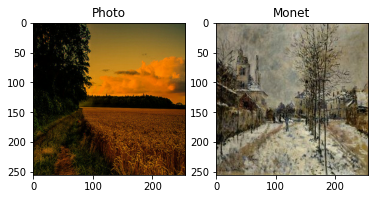

In [2]:
monet_ds, photo_ds = get_dataset()

example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

### Training

In [9]:
ganModel = get_model()

ganModel.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

Epoch 1/25
300/300 [==============================] - 51s 119ms/step - monet_gen_loss: 4.0624 - photo_gen_loss: 4.0968 - monet_disc_loss: 0.7440 - photo_disc_loss: 0.7446
Epoch 2/25
300/300 [==============================] - 36s 119ms/step - monet_gen_loss: 3.3805 - photo_gen_loss: 3.3688 - monet_disc_loss: 0.6566 - photo_disc_loss: 0.6657
Epoch 3/25
300/300 [==============================] - 36s 119ms/step - monet_gen_loss: 3.0879 - photo_gen_loss: 3.1041 - monet_disc_loss: 0.6508 - photo_disc_loss: 0.6573
Epoch 4/25
300/300 [==============================] - 36s 119ms/step - monet_gen_loss: 2.9628 - photo_gen_loss: 2.9912 - monet_disc_loss: 0.6451 - photo_disc_loss: 0.6508
Epoch 5/25
300/300 [==============================] - 36s 119ms/step - monet_gen_loss: 2.8725 - photo_gen_loss: 2.9080 - monet_disc_loss: 0.6409 - photo_disc_loss: 0.6458
Epoch 6/25
300/300 [==============================] - 36s 119ms/step - monet_gen_loss: 2.8059 - photo_gen_loss: 2.8442 - monet_disc_loss: 0.6401 

### Show some reuslts

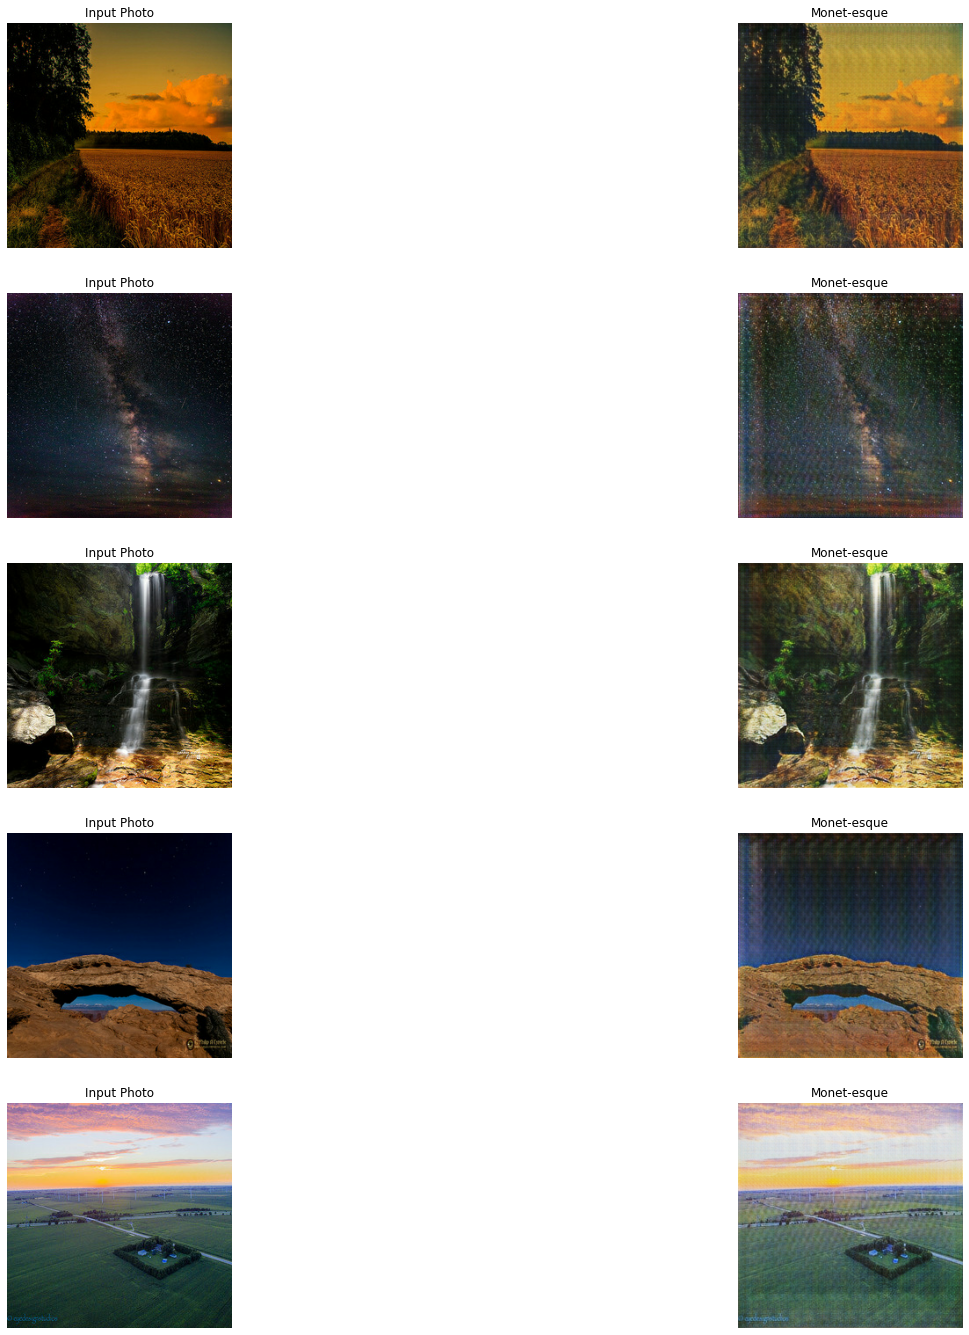

In [13]:
monet_generator = ganModel.m_gen

_, ax = plt.subplots(5, 2, figsize=(24, 24))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

### Save as zip

In [ ]:
import PIL
import shutil
! mkdir ./ret_imgs
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("./ret_imgs/" + str(i) + ".jpg")
    i += 1
import shutil
shutil.make_archive("./ret_imgs", 'zip', "./ret_imgs")